In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches

In [3]:
import wandb
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [15]:
bright_factor = 0
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='RNN_DANN_SWEEP', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.is_dann": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='RNN_DANN_SWEEP', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1, "config.is_dann": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='RNN_DANN_SWEEP', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bright_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0, "config.lambda_homeo":0.01 }, order="-summary_metrics.test_acc")

(array([80., 82., 84., 86., 88., 90.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

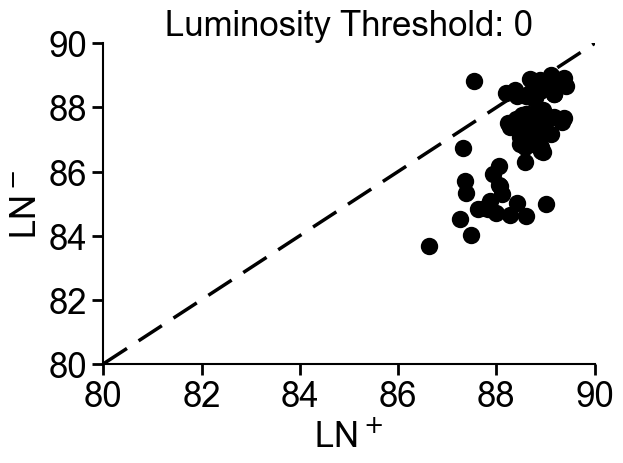

In [18]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black")




ax.set_xlabel(f"LN$^+$", fontsize=25)
ax.set_ylabel("LN$^-$", fontsize=25)
ax.set_title(f"Luminosity Threshold: {bright_factor}", fontsize=25)
list_line = range(100)
ax.set_xlim(80, 90)
ax.set_ylim(80, 90)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

# Set larger font sizes for the tick numbers
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

In [ ]:
fig = plt.figure(layout="constrained")

plt.rcParams['figure.constrained_layout.use'] = False


gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mu_dann = []

mu_dann.append([run_van.summary['eval_ei_cell_2_mu'] for run_van in runs_dict["runs_homeostasis"]])

mu_dann.append([run_van.summary['eval_ei_cell_2_mu'] for run_van in runs_dict["runs_vanilla_dann"]])

var_dann = []

var_dann.append([run_van.summary['eval_ei_cell_2_var'] for run_van in runs_dict["runs_homeostasis"]])

var_dann.append([run_van.summary['eval_ei_cell_2_var'] for run_van in runs_dict["runs_vanilla_dann"]])

bp1 = ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["green", '#eb3920']

# Iterate over each median line and set its color
for median, color in zip(bp1['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

bp2 = ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["green", '#eb3920']

# Iterate over each median line and set its color
for median, color in zip(bp2['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

# Create custom x-axis tick labels
custom_xticks = ["Homeostasis", "No Homeostasis"]
ax1.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax1.set_xticklabels(custom_xticks, fontsize=25)
ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax2.set_xticklabels(custom_xticks, fontsize=25)
ax2.axhline(y=1, color='black', linestyle='dotted')

ax1.set_ylabel('First Moment', fontsize=20)
ax1.set_ylabel('$\mathbb{E}[h_l]$', fontsize=25)
ax2.set_ylabel('Second Moment', fontsize=20)
ax2.set_ylabel('$\mathbb{E}[h^2_l]$', fontsize=25)
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
ax2.set_yscale('log')

# Set larger font sizes for the tick numbers
plt.yticks(fontsize=15)
ax1.set_title("Across 100 Hparams", fontsize=20)

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])

77


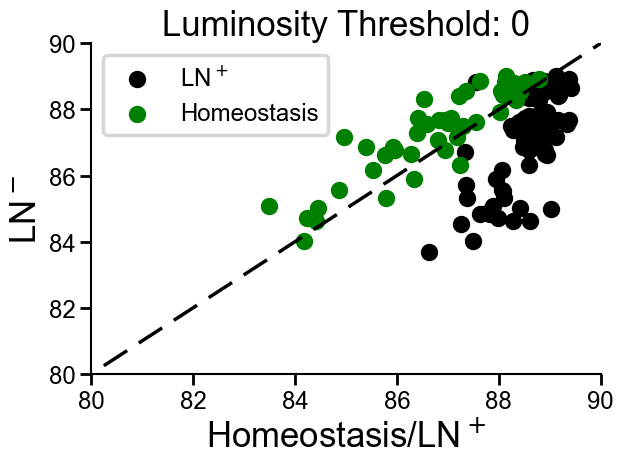

In [19]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", alpha=1, label=f"LN$^+$" if label_flag else None)
            label_flag = False

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_homeostasis"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="green", label=f"Homeostasis" if label_flag else None)
            label_flag = False


print(len(runs_dict["runs_vanilla_dann_layernorm"]))
#ax.set_xlabel(f"LN$^+$")
ax.set_xlabel("Homeostasis/LN$^+$", fontsize=25)
ax.set_ylabel("LN$^-$", fontsize=25)
ax.set_title(f"Luminosity Threshold: {bright_factor}", fontsize=25)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
list_line = range(100)
ax.set_xlim(80, 90)
ax.set_ylim(80, 90)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.legend()
# Set larger font sizes for the tick numbers



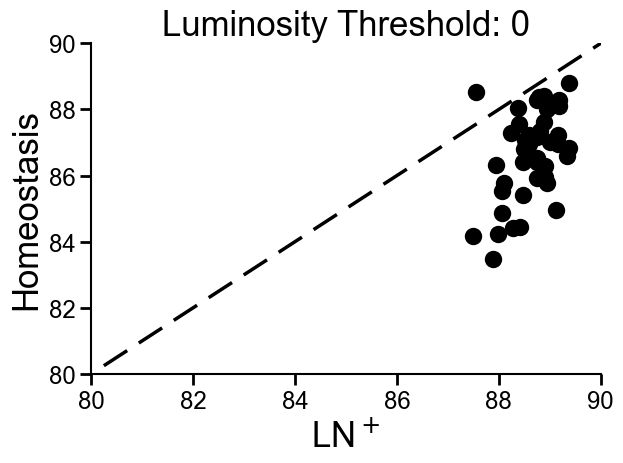

In [20]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_homeostasis"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_homeostasis"][top].summary['test_acc']
    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_homeostasis"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", alpha=1)



#ax.set_xlabel(f"LN$^+$")
ax.set_xlabel("LN$^+$", fontsize=25)
ax.set_ylabel("Homeostasis", fontsize=25)
ax.set_title(f"Luminosity Threshold: {bright_factor}", fontsize=25)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
list_line = range(100)
ax.set_xlim(80, 90)
ax.set_ylim(80, 90)
ax.plot(list_line, list_line, color='black', linestyle='--')
# Set larger font sizes for the tick numbers



Text(0.5, 1.0, 'Luminosity Threshold: 0')

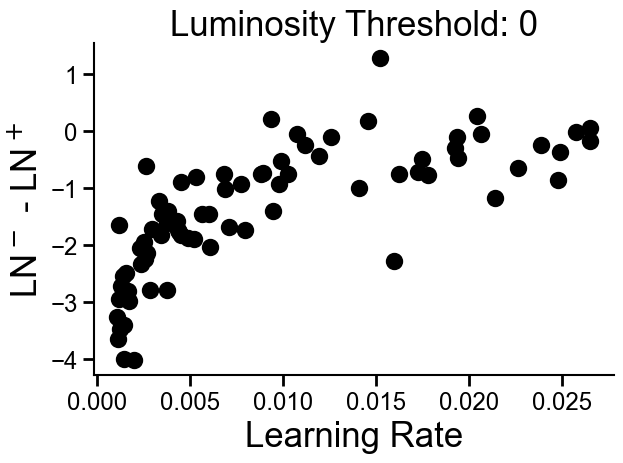

In [21]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(runs_dict["runs_vanilla_dann"][top].config['lr'] , vanilla_dann_acc- rn.summary['test_acc'], color="black", alpha=1)



#ax.set_xlabel(f"LN$^+$")
ax.set_xlabel("Learning Rate", fontsize=25)
ax.set_ylabel("LN$^-$ - LN$^+$", fontsize=25)
ax.set_title(f"Luminosity Threshold: {bright_factor}", fontsize=25)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
# list_line = range(100)
# # ax.set_xlim(60, 80)
# # ax.set_ylim(60, 80)
# ax.plot(list_line, list_line, color='black', linestyle='--')
# Set larger font sizes for the tick numbers

/home/mila/r/roy.eyono/venvs/homeostatic_dann_2025/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mila/r/roy.eyono/venvs/homeostatic_dann_2025/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mila/r/roy.eyono/venvs/homeostatic_dann_2025/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mila/r/roy.eyono/venvs/homeostatic_dann_2025/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/mila/r/roy.eyono/venvs/homeostatic_dann_2025/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encount

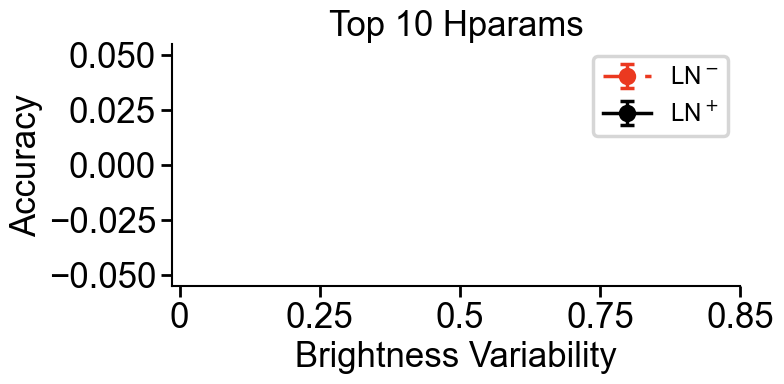

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
brightness_factor = [0, 0.25, 0.5, 0.75, 0.85] #, 1]
noln_acc = []
ln_acc = []
homeo_inhib_acc = []
noln_err = []
ln_err = []
homeo_inhib_err = []

top_n_architectures = 10

for bf in brightness_factor:

    runs_vanilla_dann = fetch_runs(api, entity='project_danns', project_name='MNIST_RNN_DANN', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 0, "config.is_dann": 0,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    # runs_homeostasis = fetch_runs(api, entity='project_danns', project_name='MNIST_RNN_DANN', filters={"config.dataset": "fashionmnist", 
    #                                                             "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 1, "config.normtype_detach": 1,
    #                                                             "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_vanilla_dann_layernorm = fetch_runs(api, entity='project_danns', project_name='MNIST_RNN_DANN', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 1, "config.is_dann": 0,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    
                                                                
    noln_acc.append(np.median([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    # homeo_inhib_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))
    noln_err.append(np.std([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    # homeo_inhib_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))

# ax.plot(range(len(noln_acc)), noln_acc, color='red')
# ax.plot(range(len(homeo_inhib_acc)), homeo_inhib_acc, color='blue')


ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='#eb3920')
# ax.errorbar(range(len(homeo_inhib_acc)), homeo_inhib_acc, yerr=homeo_inhib_err, fmt='-o', label='DetachLN$^+$', capsize=5, color='green')
ax.errorbar(range(len(ln_acc)), ln_acc, yerr=ln_err, fmt='-o',  label='LN$^+$', capsize=5, color='black')
plt.xticks(range(len(noln_acc)), [str(ele) for ele in brightness_factor], fontsize=25)
plt.legend()


ax.set_xlabel('Brightness Variability', fontsize=25)
ax.set_ylabel(f'Accuracy', fontsize=25)
ax.set_title(f'Top {top_n_architectures} Hparams', fontsize=25)


# Set larger font sizes for the tick numbers
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Get the current x and y ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

#ax.set_ylim(82,90)

# Set only the first and last x and y ticks
#ax.set_xticks([x_ticks[0], x_ticks[-1]])
#ax.set_yticks([y_ticks[0], y_ticks[-1]])



In [27]:
# NOTE: Take long to run

import matplotlib.gridspec as gridspec

plt.close('all')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

best_n_runs = 1
first_moment = []
second_moment = []

for idx, run in enumerate(runs_dict["runs_homeostasis"][:best_n_runs]):
    first_val = []
    second_val = []
    for row in run.scan_history(keys=["train_fc1_mu", "train_fc1_var"]):
        first_val.append(row["train_fc1_mu"])
        second_val.append(row["train_fc1_var"])
    first_moment.append(first_val)
    second_moment.append(second_val)

first_moment = np.mean(first_moment, axis=0)
second_moment = np.mean(second_moment, axis=0)

# Moving average with a window of 5,000
window_size = 10000
first_moment = np.convolve(first_moment, np.ones(window_size)/window_size, mode='valid')
second_moment = np.convolve(second_moment, np.ones(window_size)/window_size, mode='valid')

ax1.plot(first_moment, color='green', label="Homeostasis" if idx==0 else None)
ax2.plot(second_moment, color='green', label="Second Moment" if idx==0 else None)

ax2.set_xlabel("Steps", fontsize=25)

ax1.set_ylabel('$\mathbb{E}[h_l]$', fontsize=25)
ax2.set_ylabel('$\mathbb{E}[h^2_l]$', fontsize=25)

ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.axhline(y=1, color='black', linestyle='dotted')


ax1.tick_params(axis='x', labelsize=25)  # Set the font size for x-ticks
ax1.tick_params(axis='y', labelsize=25)  # Set the font size for x-ticks
ax2.tick_params(axis='x', labelsize=25)  # Set the font size for x-ticks
ax2.tick_params(axis='y', labelsize=25)  # Set the font size for x-ticks
# Section: No Homeostasis

best_n_runs = 1
no_homeostasis_first_moment = []
no_homeostasis_second_moment = []

for idx, run in enumerate(runs_dict["runs_vanilla_dann"][:best_n_runs]):
    first_val = []
    second_val = []
    for row in run.scan_history(keys=["train_fc1_mu", "train_fc1_var"]):
        first_val.append(row["train_fc1_mu"])
        second_val.append(row["train_fc1_var"])
    no_homeostasis_first_moment.append(first_val)
    no_homeostasis_second_moment.append(second_val)

no_homeostasis_first_moment = np.mean(no_homeostasis_first_moment, axis=0)
no_homeostasis_second_moment = np.mean(no_homeostasis_second_moment, axis=0)

# Moving average with a window of 5,000
window_size = 10000
no_homeostasis_first_moment = np.convolve(no_homeostasis_first_moment, np.ones(window_size)/window_size, mode='valid')
no_homeostasis_second_moment = np.convolve(no_homeostasis_second_moment, np.ones(window_size)/window_size, mode='valid')

ax1.plot(no_homeostasis_first_moment, color='#eb3920', label="No Homeostasis" if idx==0 else None)
ax2.plot(no_homeostasis_second_moment, color='#eb3920', label="Second Moment" if idx==0 else None)

ax1.tick_params(axis='x', labelsize=25)  # Set the font size for x-ticks
ax1.tick_params(axis='y', labelsize=25)  # Set the font size for x-ticks
ax2.tick_params(axis='x', labelsize=25)  # Set the font size for x-ticks
ax2.tick_params(axis='y', labelsize=25)  # Set the font size for x-ticks

ax1.legend(fontsize=12)

ax1.set_title("Best HParams")


gs1.tight_layout(fig)

In [13]:
# Specify the file path
file_path = 'robustness_data.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    acc_s = json.load(file)

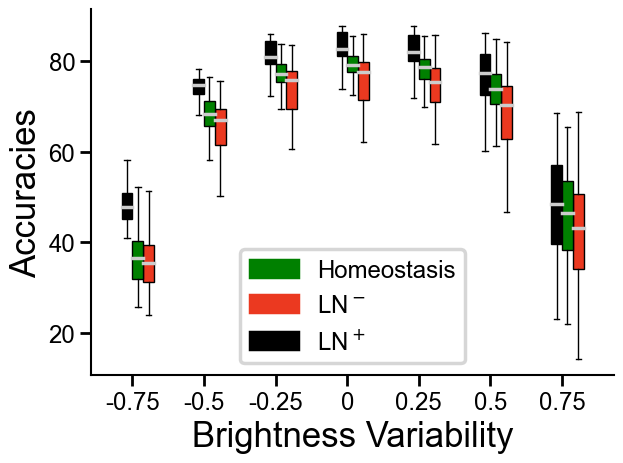

In [15]:
# Preparing data for the box plot
nested_keys = sorted(list(acc_s['runs_vanilla_dann_layernorm'].keys()))  # Use sorted keys for consistency
nested_keys = ['-0.75', '-0.5', '-0.25', '0', '0.25', '0.5', '0.75']
homeostasis_data = [acc_s['runs_homeostasis'][key] for key in nested_keys]
vanilla_dann_data = [acc_s['runs_vanilla_dann'][key] for key in nested_keys]
vanilla_dann_layernorm_data = [acc_s['runs_vanilla_dann_layernorm'][key] for key in nested_keys]

# Plotting
# plt.figure(figsize=(10, 8))

# Adding boxplots for both runs_homeostasis and runs_vanilla_dann on the same x-ticks
positions = np.arange(len(nested_keys))
box_width = 0.15  # Width for the boxplots


plt.boxplot(vanilla_dann_layernorm_data, positions=positions - box_width / 2, widths=box_width, patch_artist=True, medianprops=dict(color='#cccccc', linewidth=2.5), boxprops=dict(facecolor='black'), showfliers=False)
plt.boxplot(vanilla_dann_data, positions=positions + 1.5*box_width , widths=box_width, patch_artist=True, medianprops=dict(color='#cccccc', linewidth=2.5), boxprops=dict(facecolor='#eb3920'), showfliers=False)
plt.boxplot(homeostasis_data, positions=positions + box_width / 2, widths=box_width, patch_artist=True, medianprops=dict(color='#cccccc', linewidth=2.5), boxprops=dict(facecolor='green'), showfliers=False)

# Customizing the plot
plt.xticks(ticks=positions, labels=[str(key) for key in nested_keys])
plt.xlabel('Brightness Variability', fontsize=25)
plt.ylabel('Accuracies', fontsize=25)
# Creating legend based on face colors
lightblue_patch = mpatches.Patch(color='green', label='Homeostasis')
lightsalmon_patch = mpatches.Patch(color='black', label='LN$^+$')
lightgreen_patch = mpatches.Patch(color='#eb3920', label='LN$^-$')
plt.legend(handles=[lightblue_patch, lightgreen_patch, lightsalmon_patch])
plt.tight_layout()

# Set larger font sizes for the tick numbers
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)

# Display the plot
plt.show()